In [1]:
# rsync -av -e 'ssh -o ProxyCommand="ssh -q -W %h:%p s2016765@ssh.inf.ed.ac.uk"' s2016765@mlp.inf.ed.ac.uk:/home/s2016765/final_project/experiments/resnet50_aircraft_224_224 experiments/

import os
import random

import torch
import timm
from PIL import Image
import cv2
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50, vit_b_16, ViT_B_16_Weights, ResNet50_Weights

/home/posiedon72/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Accuracy and loss

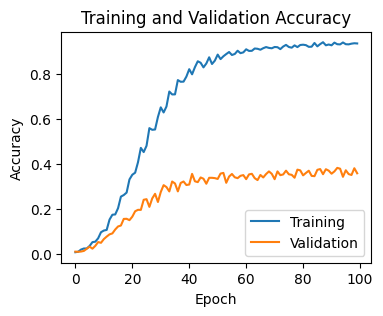

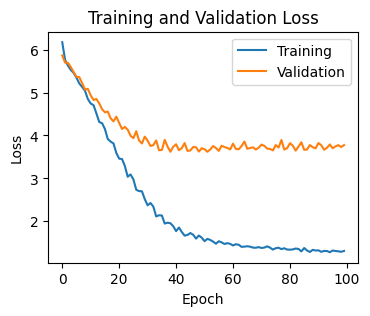

In [2]:

# Read the CSV file
df = pd.read_csv('experiments/vitb16_im_birds_224_224/result_outputs/summary.csv')

# Plotting the training and validation accuracy
plt.figure(figsize=(4, 3))
plt.plot(df['train_acc'], label='Training')
plt.plot(df['val_acc'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(4, 3))
plt.plot(df['train_loss'], label='Training')
plt.plot(df['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Image transformation testing

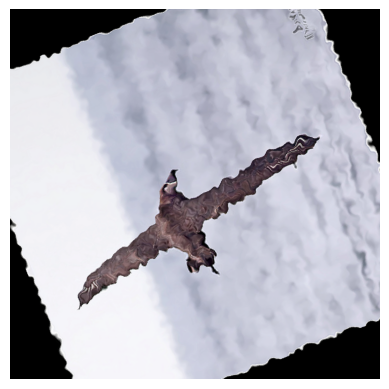

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((768, 768), interpolation=Image.BICUBIC),  # Resize to 224x224
    # transforms.CenterCrop(75),  # Crop to 224x224 at the center
    # transforms.Resize((512, 512), interpolation=Image.BICUBIC),
    transforms.ElasticTransform(200.0),
    transforms.RandomRotation(180),
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Path to your image
image_path = "data/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg"

# Load and apply transformations
image = Image.open(image_path)
transformed_tensor = transform(image)

# Reverse normalization and convert tensor to PIL image
reverse_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
reverse_transform = transforms.Compose([transforms.Normalize((0, 0, 0), (1, 1, 1)), transforms.ToPILImage()])
transformed_image = reverse_transform(reverse_normalize(transformed_tensor))

# Display the transformed image
plt.imshow(transformed_image)
plt.axis('off')
plt.show()

# Gradient visualisation

In [4]:
def load_weights(model, state):
    for key in model.state_dict():
        if 'num_batches_tracked' in key:
            continue
        p = model.state_dict()[key]
        if 'model.module.' + key in state['network']:
            ip = state['network']['model.module.' + key]
            if p.shape == ip.shape:
                p.data.copy_(ip.data)  # Copy the data of parameters
            else:
                print(
                    'could not load layer: {}, mismatch shape {} ,{}'.format(key, (p.shape), (ip.shape)))
        else:
            print('could not load layer: {}, not in checkpoint'.format(key))
    return model

In [5]:
def get_model(model, pretrain_scheme, res, dataset, num_classes=None):
    model_path = f'experiments/{model}_{pretrain_scheme}_{dataset}_{res}_{res}/saved_models/train_model_latest'
    state = torch.load(model_path, map_location=torch.device('cpu'))
    if model == 'resnet50':
        model = resnet50()
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
        model = load_weights(model, state)
    elif model == 'vitb16':
        if pretrain_scheme == 'imagenet':
            model = vit_b_16()
            model.heads[0].out_features = num_classes
            model.load_state_dict(state_dict=state['network'])
        elif pretrain_scheme == 'imagenet21k':
            model_kwargs = dict(
            patch_size=16, embed_dim=768, depth=12, num_heads=12, qkv_bias=False)
            model = timm.models.vision_transformer._create_vision_transformer('vit_base_patch16_224_in21k',
                                                                            pretrained=False,
                                                                            num_classes=num_classes, **model_kwargs)
            model.load_state_dict(state_dict=state['network'])
            
    model.eval()
    return model

class_dict = {'birds': 200, 'aircraft': 100}

In [6]:
class ResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.model = model
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
                
    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]
    
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)
    
def get_image_from_url(im_path, res=224):
    """A function that gets a URL of an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(Image.open(im_path))
    img = cv2.resize(img, (res, res))
    rgb_img_float = np.float32(img) / 255
    transform = transforms.Compose([
        # transforms.CenterCrop(0.875 * res),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    input_tensor = transform(rgb_img_float).unsqueeze(0)
    return img, rgb_img_float, input_tensor

In [7]:
model = get_model(model='resnet50', pretrain_scheme='im', res=224, dataset='birds', num_classes=class_dict['birds'])
target_layers = [model.layer4[-1]]

In [8]:
image_dir = "data/CUB_200_2011/images/"
image_paths = []

# Traverse all directories in the image directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Get the full path of each image file
        image_path = os.path.join(root, file)
        image_paths.append(image_path)

# Select 5 random image paths
image_paths = random.sample(image_paths, 5)

In [9]:
image_grads = []
for image_path in image_paths:
    img, img_float, input_tensor = get_image_from_url(image_path)
    concept_features = model(input_tensor)[0, :]
    targets = [SimilarityToConceptTarget(concept_features)]
    with GradCAM(model=model,
             target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    cam_image = show_cam_on_image(img_float, grayscale_cam, use_rgb=True)
    image_grads.append(cam_image)

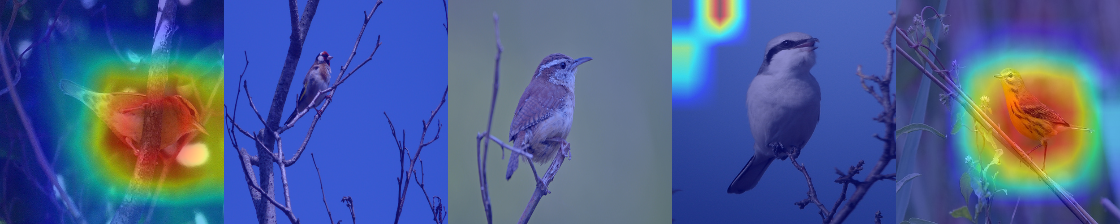

In [10]:
Image.fromarray(np.hstack(image_grads))